# 编程联系 3 ： 多类别分类和神经网络

## 1 多类别分类
在本次练习，将使用逻辑回归和神经网络来识别手写数字（0 - 9）。在本次练习中将像你展示如何使用已学习的方法应用到这类分类任务中。
在第一部分中，你将扩展先前实现的逻辑回归，并应用与一对多的分类。

### 1.1 数据集
在 ex3data1.mat 中包含 $5000$ 个手写数字的训练示例，每个示例都是 $20px \times 20px$ 的数字灰度图片。每一个像素由一个浮点数表示该位置的灰度值。$20 \times 20$ 的的像素网格被“展开”为 $400$ 维的向量。在我们的数据矩阵 $X$ 中，每一个训练例子都变成一行。这将给我们一个 $5000 \times 400$ 的矩阵 $X$，其中每行就是一个手写数字图像的训练示例。
$$
X = 
\left[ 
\begin{matrix}
— (x^{(1)})^T — \\
— (x^{(2)})^T — \\
\vdots \\
— (x^{(m)})^T —
\end{matrix}
\right]
$$

训练集的第二个部分是包含训练集标签的 $5000$ 维向量 $y$。这里没有零索引，所以将 $0$ 映射到 $10$，而数字 $1$ 到 $9$ 则按自然顺序标记为 $1$ 到 $9$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import loadmat
data = loadmat('./data/ex3data1.mat')

data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [2]:
data['X'].shape, data['y'].shape

((5000, 400), (5000, 1))

### 1.2 数据可视化

随机从 $X$ 中选择100行数据展示

In [3]:
sample_idx = np.random.choice(data['X'].shape[0], 100)
sample_images = data['X'][sample_idx, :]
sample_images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

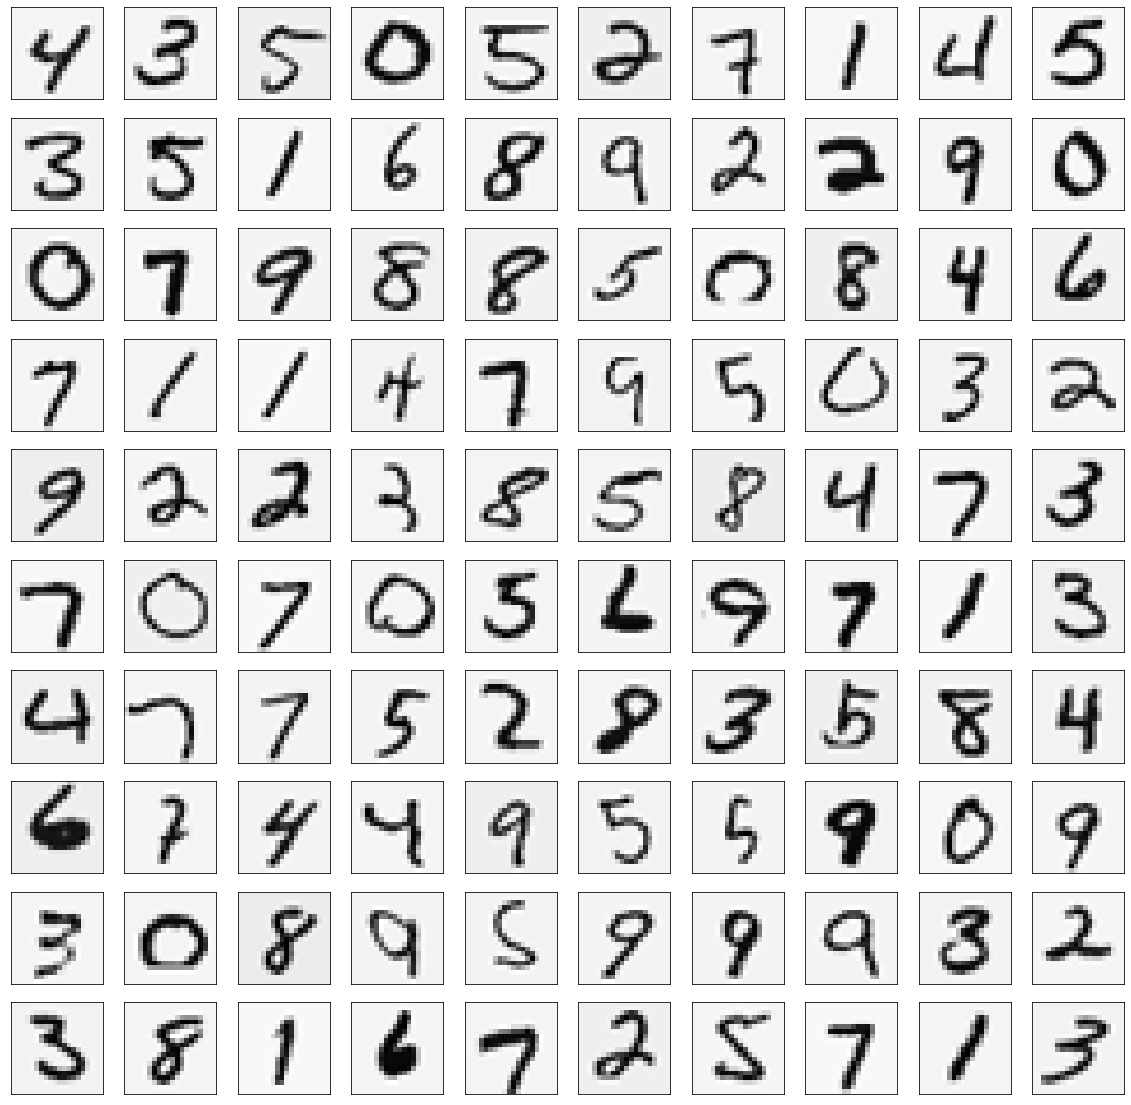

In [4]:
fig, ax_array = plt.subplots(10, 10, sharex=True, sharey=True, figsize=(20, 20))
for i, ax in enumerate(ax_array.flat):
    ax.imshow(sample_images[i].reshape(20, 20).T, cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

### 1.3 向量化逻辑回归
你将使用多个一对多的逻辑回归模型来建立一个多类别分类器。因为有10个类别，需要训练10个独立的逻辑回归分类器。为了使训练有效，确保代码良好的向量化很重要。这本节中，您将使用一个不使用任何for循环的向量化版逻辑回归。

#### 1.3.1 向量化代价函数
我们将从编写成本函数的向量化版本开始，（非正则）逻辑回归中，代价函数为
$$
J\left( \theta \right) = \frac{1}{m} \sum_{i=1}^{m} [ -y^{\left(i\right)} \log{\left(h_\theta \left(x^{\left(i\right)}\right) \right)} - \left(1 - y^{\left(i\right)}\right) log{\left( 1 - h_\theta \left(x^{\left(i\right)}\right) \right)} ]
$$

为了计算求和中的每个元素，我们必须计算每个示例 $i$ 的 $h_{\theta}(x^{(i)})$，其中 $h_{\theta}(x^{(i)}) = g(\theta^Tx^{(i)})$ 且激活函数 $g(z) = \frac{1}{1 + e^{-z}}$。结果证明，我们可以使用矩阵乘法快速计算所有例子的值。我们定义 $X$ 和 $\theta$ 为
$$
X = 
\left[ 
\begin{matrix}
— (x^{(1)})^T — \\
— (x^{(2)})^T — \\
\vdots \\
— (x^{(m)})^T —
\end{matrix}
\right] \  and \  
\theta = 
\left[ 
\begin{matrix}
\theta_0 \\
\theta_1 \\
\vdots \\
\theta_n \\
\end{matrix}
\right]
$$

然后通过计算矩阵乘积 $X \theta$，可得
$$
X \theta = 
\left[ 
\begin{matrix}
— (x^{(1)})^T \theta — \\
— (x^{(2)})^T \theta — \\
\vdots \\
— (x^{(m)})^T \theta — \\
\end{matrix}
\right]
=
\left[ 
\begin{matrix}
— \theta^T (x^{(1)}) — \\
— \theta^T (x^{(2)}) — \\
\vdots \\
— \theta^T (x^{(m)}) — \\
\end{matrix}
\right]
$$

在最后一个等式中，我们使用定理：如果 $a$ 和 $b$ 都是向量，则 $a^Tb = b^Ta$ 。这使我们能在一行代码中计算所有示例 $i$ 的乘积 $\theta^T x^{(i)}$


In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [ ]:
def unregularized_cost(theta, X, y):
    theta, X, y = np.mat(theta), np.mat(X), np.mat(y)
    first = (-y * np.log(sigmoid(X @ theta))) - (1 - y) * np.log(1 - sigmoid(X @ theta))